In [1]:
from __future__ import print_function, division

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from skimage import io, transform

from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
# import pandas as pd

In [3]:
# a = pd.read_csv('./Dataset/FERPlus/fer2013testing.csv')

In [4]:
# training_csv = a[a['Usage'] == 'Training']
# training_csv = training_csv.drop(['Usage'], axis = 1)
# training_csv.to_csv('./Dataset/FERPlus/Training.csv')

In [5]:
# validation_csv = a[a['Usage'] == 'PublicTest']
# validation_csv = validation_csv.drop(['Usage'], axis = 1)
# validation_csv.to_csv('./Dataset/FERPlus/Validation.csv')

In [6]:
# test_csv = a[a['Usage'] == "PrivateTest"]
# test_csv = test_csv.drop(['Usage'], axis = 1)
# test_csv.to_csv('./Dataset/FERPlus/Testing.csv')

In [7]:
class FacesFERPlus(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.faces = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.faces)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.faces.iloc[idx, 1])
        image = io.imread(img_name)
        image_1 = np.zeros((3, 224, 224), dtype = float)
        for i in range(48):
            for j in range(48):
                image_1[0][i+88][j+88] = image[i][j]
                image_1[1][i+88][j+88] = image[i][j]
                image_1[2][i+88][j+88] = image[i][j]
        image_1 = torch.FloatTensor(image_1.tolist())
        emotions = self.faces.iloc[idx, 2:].as_matrix()
        emotions = emotions.astype(np.long)
        emotions_1 = np.argmax(emotions)
        emotions = np.asarray([emotions_1]).astype(np.long)
        emotions = torch.LongTensor(emotions.tolist())

        if self.transform:
            image_1 = self.transform(image_1)

        sample = {'image': image_1, 'emotions': emotions}

        return image_1, emotions

In [8]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
    ])

face_dataset_train = FacesFERPlus(csv_file='Dataset/FERPlus/Training.csv',
                            root_dir='Dataset/FERPlus/FER2013Train')

face_dataset_valid = FacesFERPlus(csv_file='Dataset/FERPlus/Validation.csv',
                            root_dir='Dataset/FERPlus/FER2013Valid')


dataloaders_train = torch.utils.data.DataLoader(face_dataset_train,
                                             batch_size=1, shuffle=True,
                                             num_workers=0)

dataloaders_valid = torch.utils.data.DataLoader(face_dataset_valid,
                                             batch_size=1, shuffle=True,
                                             num_workers=0)

dataset_sizes = {len(face_dataset_train), len(face_dataset_valid)}
print(dataset_sizes)

{28561, 3579}


In [9]:
face_dataset_train[1][0].shape

torch.Size([3, 224, 224])

0 torch.Size([3, 224, 224]) torch.Size([1])
1 torch.Size([3, 224, 224]) torch.Size([1])


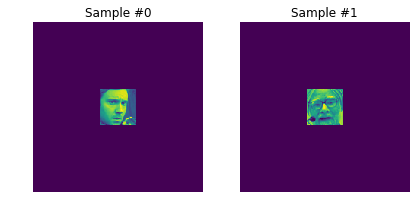

In [10]:
fig = plt.figure()

for i in range(len(face_dataset_train)):
    sample = face_dataset_train[i]

    print(i, sample[0].shape, sample[1].shape)
    ax = plt.subplot(1, 2, i + 1)
    plt.tight_layout()
    plt.imshow(sample[0][0])
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    if i == 1:
        plt.show()
        break

0 torch.Size([3, 224, 224]) torch.Size([1])
1 torch.Size([3, 224, 224]) torch.Size([1])


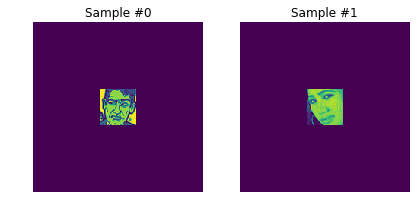

In [11]:
fig = plt.figure()

for i in range(len(face_dataset_valid)):
    sample = face_dataset_valid[i]
    print(i, sample[0].shape, sample[1].shape)

    ax = plt.subplot(1, 2, i + 1)
    plt.tight_layout()
    plt.imshow(sample[0][0])
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    if i == 1:
        plt.show()
        break

In [12]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
# #     mean = np.array([0.485, 0.456, 0.406])
# #     std = np.array([0.229, 0.224, 0.225])
# #     inp = std * inp + mean
# #     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders_train))
# print(type(inputs))
# print(inputs.shape)
# print(type(classes))
# print(classes.shape)
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out)

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in range(2):
            if phase == 0:
                dataloaders = dataloaders_train
                scheduler.step()
                model.train()
            else:
                dataloaders = dataloaders_valid
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders:
                labels = labels.squeeze(1)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 0):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 0:
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 1 and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    time_elapsed = time.time() - since
    print('Training complete in {: .0f}m {:0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("Predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, 
                      exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


In [ ]:
visualize_model(model_ft)